In [1]:
COPY_DATA = False

DATAPATH = '../data/'
XFERPATH = '~/gdrive/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906161241.csv'
VALID_FNAME = 'embed_valid_201906161241.csv'
TEST_FNAME = 'embed_test_201906161241.csv'
LSTM_TRAIN_FNAME = 'activ_train_201907261114.csv'
LSTM_VALID_FNAME = 'activ_valid_201907261114.csv'
LSTM_TEST_FNAME = 'activ_test_201907261114.csv'
MODEL_TYPE_ID = 'lrpl'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
lstm_train_from = XFERPATH + LSTM_TRAIN_FNAME
lstm_valid_from = XFERPATH + LSTM_VALID_FNAME
lstm_test_from = XFERPATH + LSTM_TEST_FNAME
if COPY_DATA:
    !cp $train_from $DATAPATH
    !cp $valid_from $DATAPATH
    !cp $test_from $DATAPATH
    !cp $lstm_train_from $DATAPATH
    !cp $lstm_valid_from $DATAPATH
    !cp $lstm_test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201907301515'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-9031,78190,28476,15732,-3761,22135
815783987784187904,2019-05-24 15:36:01+00:00,False,-1787,-57509,29939,-32859,-20955,13103
3458239641,2019-05-24 19:00:37+00:00,False,-42708,-31384,17130,60833,11307,35467
1003729876250226688,2019-05-26 12:53:00+00:00,True,-5514,61646,16234,105381,-7119,-35271
2360143940,2019-05-28 03:50:46+00:00,False,6762,-16422,-36991,29061,37017,-27550


In [6]:
# Remove duplicate index values
def remove_dups(df):
    return(df[~df.index.duplicated()])

In [7]:
df_train = remove_dups(df_train)
df_valid = remove_dups(df_valid)
df_test = remove_dups(df_test)

In [8]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34115, 513) (10908, 513) (10441, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [9]:
df_train_lstm = pd.read_csv(DATAPATH+LSTM_TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid_lstm = pd.read_csv(DATAPATH+LSTM_VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test_lstm = pd.read_csv(DATAPATH+LSTM_TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train_lstm = remove_dups(df_train_lstm)
df_valid_lstm = remove_dups(df_valid_lstm)
df_test_lstm = remove_dups(df_test_lstm)
df_train_lstm.head().iloc[:,:7]

,,male,activ0,activ1,activ2,activ3,activ4,activ5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-88660,-179010,-122969,86287,85738,-230103
815783987784187904,2019-05-24 15:36:01+00:00,False,24546,34365,30151,-30778,-102346,37726
3458239641,2019-05-24 19:00:37+00:00,False,10382,43310,-31917,-32257,-94097,-10748
1003729876250226688,2019-05-26 12:53:00+00:00,True,-58185,-141029,-130128,-8833,72594,-183613
2360143940,2019-05-28 03:50:46+00:00,False,-67848,-110605,-125555,-19150,32870,-139791


In [10]:
print(df_train_lstm.shape, df_valid_lstm.shape, df_test_lstm.shape)
print(df_train_lstm.index.get_level_values(1).min(), df_train_lstm.index.get_level_values(1).max())
print(df_valid_lstm.index.get_level_values(1).min(), df_valid_lstm.index.get_level_values(1).max())
print(df_test_lstm.index.get_level_values(1).min(), df_test_lstm.index.get_level_values(1).max())

(34115, 241) (10908, 241) (10441, 241)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [11]:
df_train.drop(['male'],axis=1).mean().mean()

252.71324352145328

In [12]:
df_train_lstm.drop(['male'],axis=1).mean().mean()

13054.855856294884

In [13]:
scaledown = 7
npc = 30

In [14]:
df_train_final = df_train.join(df_train_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_valid_final = df_valid.join(df_valid_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_test_final = df_test.join(df_test_lstm.drop(['male'],axis=1)/scaledown, rsuffix='lstm')
df_train_final.shape, df_valid_final.shape, df_test_final.shape

((34115, 753), (10908, 753), (10441, 753))

In [15]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train_final)
X_valid, y_valid = getxy(df_valid_final)
X_test, y_test = getxy(df_test_final)

In [16]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.08414473 0.05967445 0.03490426 0.02504428 0.02347338 0.02197571
 0.02083662 0.01858585 0.01835672 0.0169359  0.01591419 0.01494099
 0.01417069 0.01397894 0.01338657 0.01276766 0.01234793 0.01184324
 0.01165123 0.01146153 0.01107228 0.01065046 0.01016589 0.0099496
 0.00984195 0.00953663 0.00913053 0.00900523 0.00868021 0.00844712
 0.00817561 0.00810878 0.00779879 0.00776223 0.00757619 0.00744286
 0.00729771 0.00719404 0.00710696 0.00705318 0.00683044 0.00669094
 0.00654019 0.0064327  0.00633126 0.00609477 0.00601329 0.00594554
 0.00588085 0.00581729 0.00573598 0.00552089 0.00546884 0.00540239
 0.00536893 0.00529337 0.00522842 0.0051757  0.00508423 0.00500887
 0.00484503 0.004806   0.00469307 0.00464216]


In [17]:
model = Pipeline([('pca',  PCA(npc)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [19]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train_final, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.6940466120234519

In [20]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid_final, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3382 2074]
 [1914 3538]]


0.6395516992046276

In [21]:
accuracy_score(y_valid, y_pred>.5)

0.6343967730106344

In [22]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test_final, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3182 2038]
 [1882 3339]]


0.630118890356671

In [23]:
accuracy_score(y_test, y_test_pred>.5)

0.6245570347667848

Test set ROC AUC: 0.6766427542469586


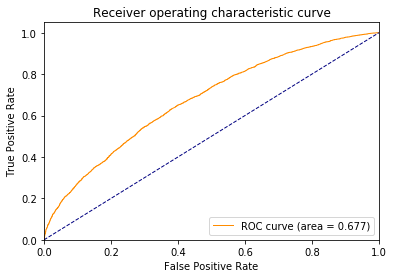

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

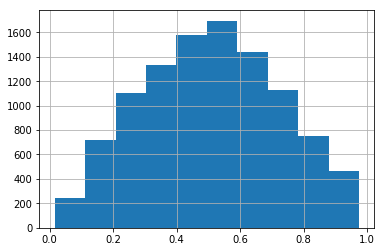

In [25]:
pd.Series(y_test_pred).hist()
plt.show()

In [26]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy','lconf95','hconf95'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    if count>0:
        actual = pd.Series(y_test)[mask].values
        pred_prob = pd.Series(y_test_pred)[mask].values
        pred_bin = pred_prob>.5
        acc = accuracy_score(actual, pred_bin)
        nsucc = sum(actual==pred_bin)
        confint = proportion_confint(nsucc, count)
        minconf = confint[0]
        maxconf = confint[1]
    else:
        acc = np.nan
        minconf = np.nan
        maxconf = np.nan
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 
                        'accuracy':[acc], 'lconf95':[minconf], 'hconf95':[maxconf]})
    df_acc = pd.concat([df_acc, row], sort=False)
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.0,0.1,195,0.871795,0.824871,0.918718
0.1,0.2,687,0.775837,0.744653,0.807021
0.2,0.3,1115,0.679821,0.652436,0.707205
0.3,0.4,1409,0.596877,0.571265,0.622490
0.4,0.5,1658,0.530760,0.506738,0.554782
0.5,0.6,1748,0.536613,0.513237,0.559990
0.6,0.7,1473,0.573659,0.548404,0.598914
0.7,0.8,1113,0.658580,0.630722,0.686438
0.8,0.9,704,0.747159,0.715053,0.779266


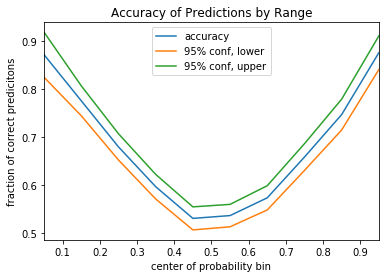

In [27]:
df_acc['avgprob'] = .5*(df_acc.minprob+df_acc.maxprob)
ax = df_acc.drop(['count','minprob','maxprob'],axis=1).set_index('avgprob').plot(
        title='Accuracy of Predictions by Range')
ax.legend(labels=['accuracy', '95% conf, lower', '95% conf, upper'])
ax.set(xlabel="center of probability bin", ylabel="fraction of correct predicitons")
plt.show()

In [28]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrpl_model_201907301515.joblib']